## Data Loading: The dataset was loaded using the pandas library from a CSV file (GoogleReview_data_cleaned.csv). Duplicate reviews were removed.

In [ ]:
import pandas as pd

df = pd.read_csv('GoogleReview_data_cleaned.csv')
df = df.drop_duplicates(subset='Review').reset_index(drop=True)
print(df.head())


                  Author  Rating  \
0            Jia Pin Lee     4.0   
1            Chui Yi Lum     2.0   
2            liezel wong     1.0   
3              Nazri Nor     1.0   
4  Fakru Imran's Channel     5.0   

                                              Review           Restaurant  \
0  Came here for the High Tea. Great service espe...  Cuisines Restaurant   
1  5 stars for the service, even though some of t...  Cuisines Restaurant   
2  Hi, thank you for your service. But! i feel so...  Cuisines Restaurant   
3  I have the worse buffer dinner ever so far. Th...  Cuisines Restaurant   
4  That's are Known 5 Elmark " 9H72 " & KDK " 3 K...  Cuisines Restaurant   

  Location  
0     Ipoh  
1     Ipoh  
2     Ipoh  
3     Ipoh  
4     Ipoh  


## 4.1 Data Preprocessing

### Step 1: Data Cleaning and Normalization - handle contractions, convert emojis to text

In [3]:
import emoji
import contractions

def clean_text(text: str) -> str:
    if not isinstance(text, str):
        text = str(text)
    text = contractions.fix(text)
    return emoji.demojize(text, delimiters=(" ", " "))

### Step 2: Tokenization and Filtering – convert text to lowercase, tokenize, and retain only alphabetic tokens (removing punctuation, numbers, URLs, and symbols)

In [4]:
import nltk
from nltk.tokenize import word_tokenize
import re

df['tokens'] = df['Review'].apply(lambda x: word_tokenize(str(x).lower()))

def keep_words_only(tokens):
    return [w for w in tokens if re.fullmatch(r'[a-z]+', w)]

df['clean_tokens'] = df['tokens'].apply(keep_words_only)
print(df['clean_tokens'].head())


0    [came, here, for, the, high, tea, great, servi...
1    [stars, for, the, service, even, though, some,...
2    [hi, thank, you, for, your, service, but, i, f...
3    [i, have, the, worse, buffer, dinner, ever, so...
4    [that, are, known, elmark, kdk, ceiling, fan, ...
Name: clean_tokens, dtype: object


### Step 3: Stopword removal – to eliminate common, non-informative words (like "the", "is", "and") that do not contribute meaningful information & remove empty reviews

In [5]:
import nltk
from nltk.corpus import stopwords

try:
    stop_list = stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
    stop_list = stopwords.words('english')

df['no_stopwords'] = df['clean_tokens'].apply(lambda tokens: [w for w in tokens if w not in stop_list])

df = df[df['no_stopwords'].apply(len) > 0].reset_index(drop=True)

print(df['no_stopwords'].head())

0    [came, high, tea, great, service, especially, ...
1    [stars, service, even, though, staffs, need, t...
2    [hi, thank, service, feel, sorry, food, deserv...
3    [worse, buffer, dinner, ever, far, spread, sma...
4    [known, elmark, kdk, ceiling, fan, ca, believe...
Name: no_stopwords, dtype: object


### Step 4: Perform Lemmatization  –  because lemmatization = stemming + ensure words in the dictionary

In [6]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize_with_pos(tokens):
    pos_tags = pos_tag(tokens)  # POS tag the tokens
    return [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags]

df['lemmatized'] = df['no_stopwords'].apply(lemmatize_with_pos)

print(df['lemmatized'].head())


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/soumyadeepsarkar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/soumyadeepsarkar/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/soumyadeepsarkar/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


0    [come, high, tea, great, service, especially, ...
1    [star, service, even, though, staff, need, tra...
2    [hi, thank, service, feel, sorry, food, deserv...
3    [bad, buffer, dinner, ever, far, spread, small...
4    [know, elmark, kdk, ceiling, fan, ca, believe,...
Name: lemmatized, dtype: object


## 4.2 Exploratory Data Analysis (EDA)

### 4.2.1 EDA #1 - Words Distribution

In [24]:
import matplotlib.pyplot as plt


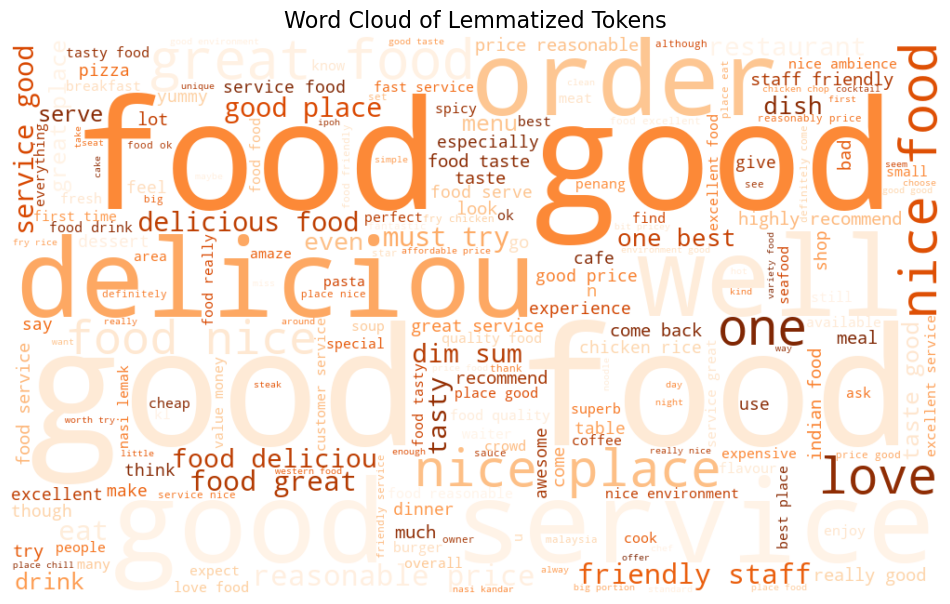

In [14]:
# !pip install wordcloud
from wordcloud import WordCloud

all_tokens = [token for tokens_list in df['lemmatized'] for token in tokens_list]


# Combine all tokens into one string
text = ' '.join(all_tokens)

# Generate word cloud
wordcloud = WordCloud(
    width=1000,
    height=600,
    background_color='white',
    colormap='Oranges',      # color scheme
    max_words=200,           # limit number of words shown
    stopwords=None           # you can import and set stopwords if needed
).generate(text)

# Plot word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Lemmatized Tokens", fontsize=16)
plt.show()


### 4.2.2 EDA #2 - Average Rating

/var/folders/dw/xnwmhg1n4_ddq424780dm5rh0000gn/T/ipykernel_21372/3556324019.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


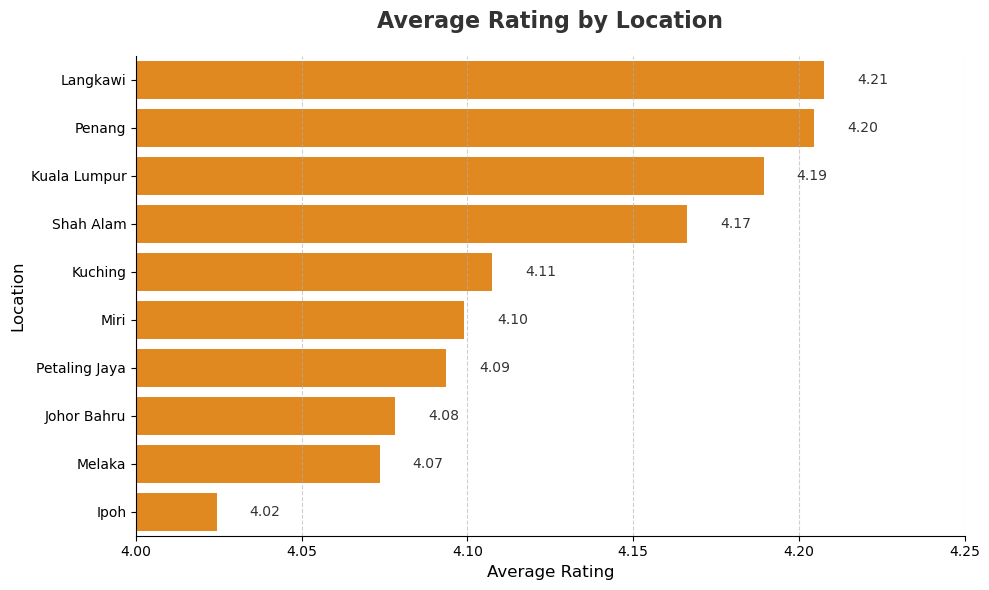

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure Rating is numeric
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')

# Replace short forms in Location column
df['Location'] = df['Location'].replace({
    'KL': 'Kuala Lumpur',
    'JB': 'Johor Bahru'
})

# Compute average rating by location
rating_by_location = df.groupby('Location')['Rating'].mean().sort_values(ascending=False)

# --- Plot ---
plt.figure(figsize=(10,6))
sns.barplot(
    x=rating_by_location.values,
    y=rating_by_location.index,
    palette=['#FF8C00'] * len(rating_by_location)
)

# Styling
plt.title("Average Rating by Location", fontsize=16, pad=20, fontweight='bold', color='#333333')
plt.xlabel("Average Rating", fontsize=12)
plt.ylabel("Location", fontsize=12)

# 🔸 Focus the axis between 4 and 5
plt.xlim(4.0, 4.25)

# Grid & borders
plt.grid(axis='x', linestyle='--', alpha=0.6)
sns.despine()

# Add data labels
for index, value in enumerate(rating_by_location.values):
    plt.text(value + 0.01, index, f"{value:.2f}", va='center', fontsize=10, color='#333333')

plt.tight_layout()
plt.show()


### 4.2.3 EDA #3 - Review Distribution by location

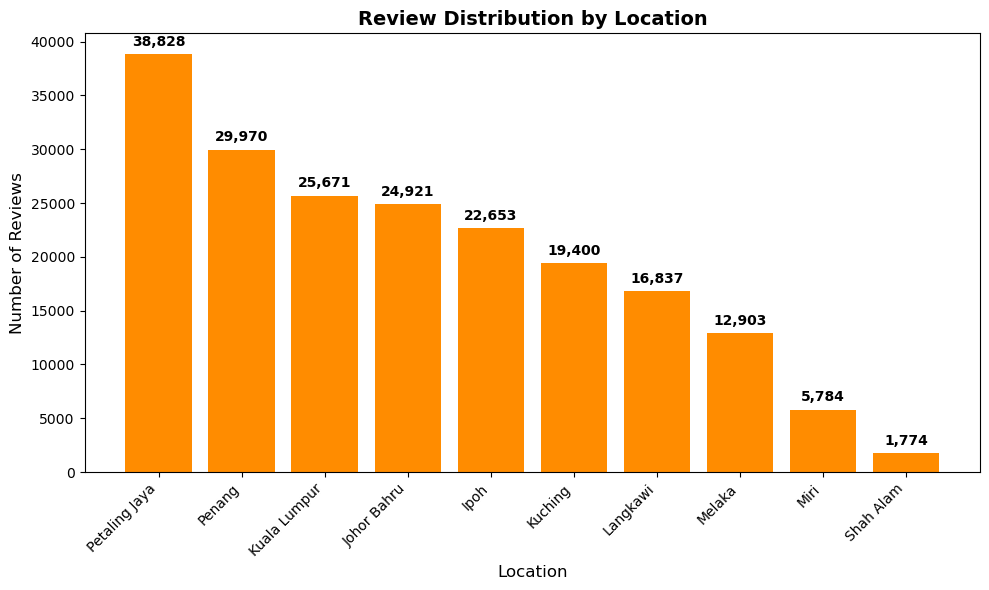

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Replace short forms in Location column for consistency
df['Location'] = df['Location'].replace({
    'KL': 'Kuala Lumpur',
    'JB': 'Johor Bahru'
})

# Count number of reviews per location
review_counts = df['Location'].value_counts().reset_index()
review_counts.columns = ['Location', 'Number of Reviews']

# Sort by number of reviews (descending)
review_counts = review_counts.sort_values(by='Number of Reviews', ascending=False)

# Plot as bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(review_counts['Location'], review_counts['Number of Reviews'], color= '#FF8C00')

# Add data labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 500,  # small offset above the bar
             f'{int(yval):,}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Chart titles and formatting
plt.title('Review Distribution by Location', fontsize=14, fontweight='bold')
plt.xlabel('Location', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [17]:
# !pip install folium
import pandas as pd
import folium

# --- Step 1: Prepare your data ---
review_counts = df['Location'].replace({
    'KL': 'Kuala Lumpur',
    'JB': 'Johor Bahru'
}).value_counts().reset_index()
review_counts.columns = ['Location', 'Number of Reviews']

# --- Step 2: Add approximate coordinates for each city ---
coords = {
    'Kuala Lumpur': [3.1390, 101.6869],
    'Penang': [5.4164, 100.3327],
    'Johor Bahru': [1.4927, 103.7414],
    'Ipoh': [4.5975, 101.0901],
    'Melaka': [2.1896, 102.2501],
    'Shah Alam': [3.0738, 101.5183],
    'Petaling Jaya': [3.1073, 101.6067],
    'Langkawi': [6.35, 99.8],
    'Kuching': [1.5533, 110.3592],
    'Miri': [4.3993, 113.9914]
}

# Merge coordinates
review_counts['Latitude'] = review_counts['Location'].map(lambda x: coords[x][0])
review_counts['Longitude'] = review_counts['Location'].map(lambda x: coords[x][1])

# --- Step 3: Create the map ---
m = folium.Map(location=[4.5, 108], zoom_start=6, tiles='cartodb positron')

# --- Step 4: Add circle markers for each city ---
for _, row in review_counts.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=row['Number of Reviews'] / review_counts['Number of Reviews'].max() * 25,  # scale bubble size
        color='#FF8C00',
        fill=True,
        fill_color='#FF8C00',
        fill_opacity=0.7,
        popup=f"{row['Location']}: {row['Number of Reviews']} reviews"
    ).add_to(m)

# Display the map
m


## 5.1 Perform Exploratory Data Analysis (EDA)

### 5.1.1 EDA #1 - Zipf law

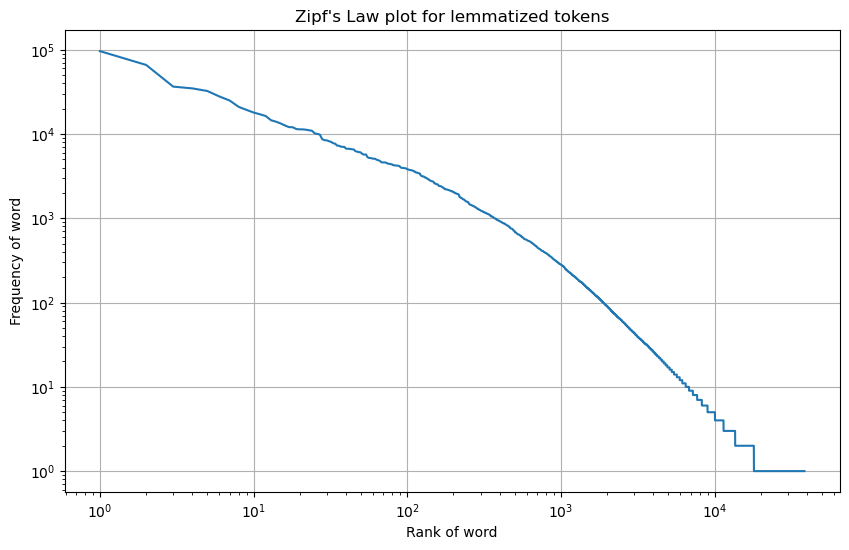

In [18]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

all_words = [word for tokens in df['lemmatized'] for word in tokens]

word_freq = Counter(all_words)

freq_sorted = sorted(word_freq.values(), reverse=True)

ranks = np.arange(1, len(freq_sorted) + 1)

plt.figure(figsize=(10,6))
plt.loglog(ranks, freq_sorted)
plt.xlabel('Rank of word')
plt.ylabel('Frequency of word')
plt.title('Zipf\'s Law plot for lemmatized tokens')
plt.grid(True)
plt.show()

### 5.1.2 EDA #2 - Sentiment Distribution (Class Imbalance Check)

/var/folders/dw/xnwmhg1n4_ddq424780dm5rh0000gn/T/ipykernel_21372/524738810.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='sentiment', data=df, palette='Set2')


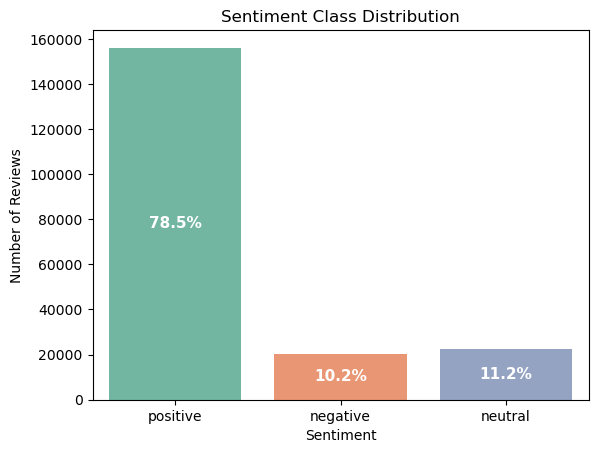

sentiment
positive    156056
neutral      22323
negative     20362
Name: count, dtype: int64
sentiment
positive    78.522298
neutral     11.232207
negative    10.245495
Name: proportion, dtype: float64


In [19]:
def map_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'

df['sentiment'] = df['Rating'].apply(map_sentiment)

import seaborn as sns
import matplotlib.pyplot as plt

# Create the countplot
ax = sns.countplot(x='sentiment', data=df, palette='Set2')
plt.title("Sentiment Class Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")

# --- Add percentage labels inside bars ---
total = len(df)
for p in ax.patches:
    count = int(p.get_height())
    percentage = 100 * count / total
    ax.text(
        p.get_x() + p.get_width() / 2,   # center horizontally
        count / 2,                       # middle of the bar (vertically)
        f'{percentage:.1f}%',            # only percentage
        ha='center', va='center', fontsize=11, color='white', fontweight='bold'
    )

plt.show()

# Print counts and percentages in console
print(df['sentiment'].value_counts())
print(df['sentiment'].value_counts(normalize=True) * 100)

### 5.1.3 EDA #3 - Review Length Checking

Total reviews: 198741
Total tokens: 2181120
Average tokens per review: 10.97


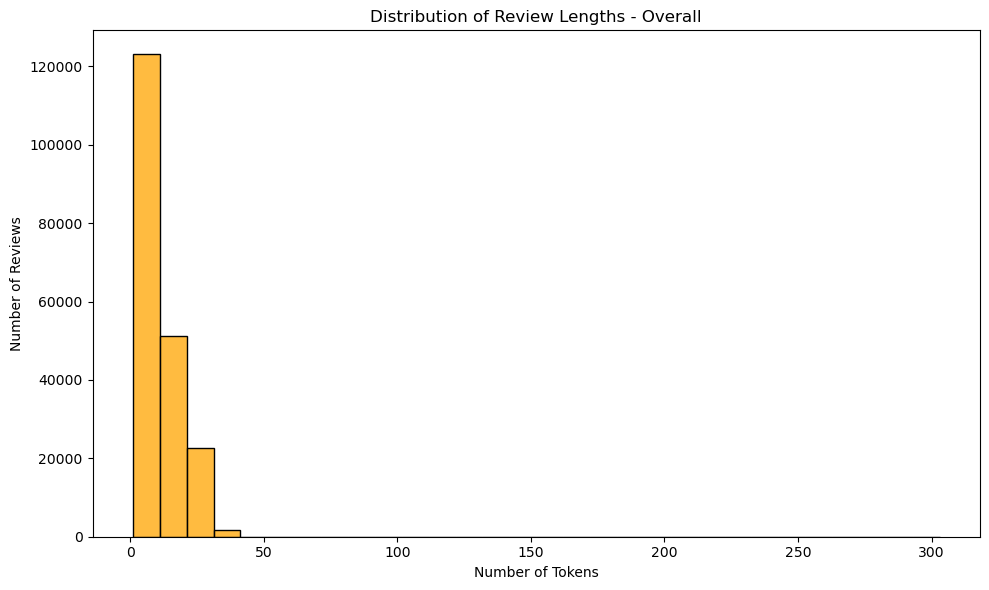

Review length stats:
count    198741.000000
mean         10.974686
std           7.834124
min           1.000000
25%           5.000000
50%           9.000000
75%          16.000000
max         303.000000
Name: review_length, dtype: float64

Review length percentiles:
90th percentile: 23.0 tokens
95th percentile: 26.0 tokens
99th percentile: 31.0 tokens


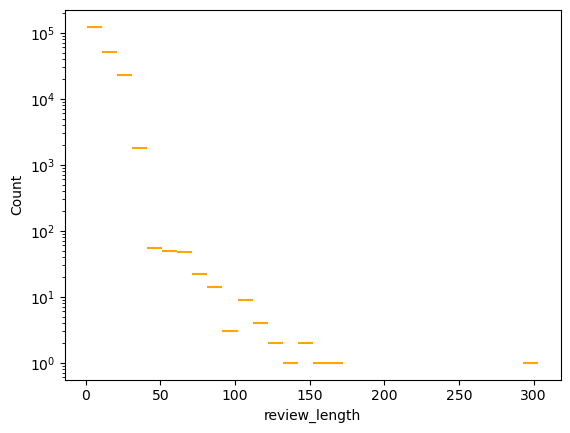

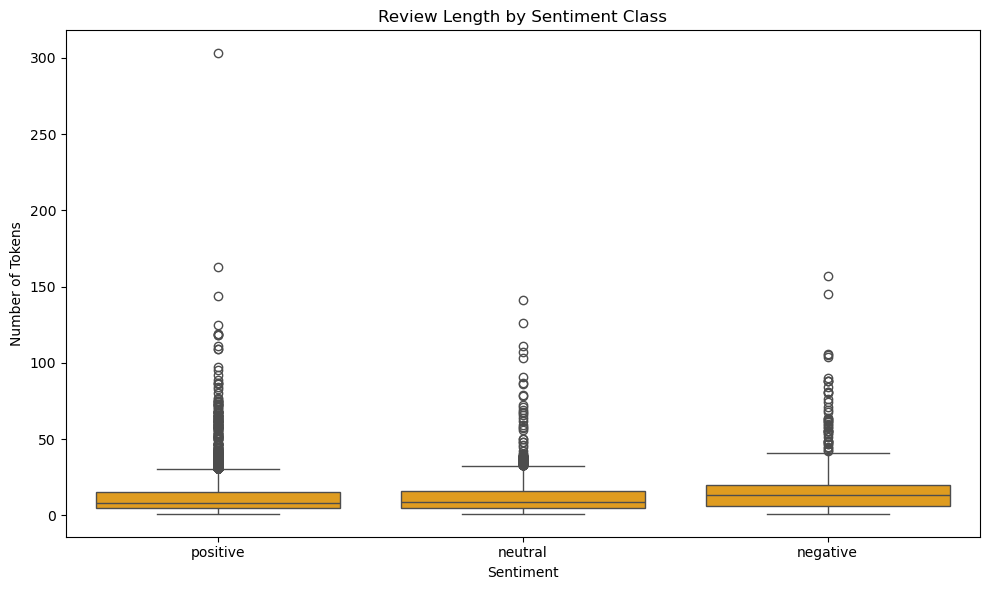

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print(f"Total reviews: {len(df)}")

df['review_length'] = df['lemmatized'].apply(len)

print(f"Total tokens: {df['review_length'].sum()}")
print(f"Average tokens per review: {df['review_length'].mean():.2f}")

plt.figure(figsize=(10,6))
sns.histplot(df['review_length'], bins=30, color='orange')
plt.title("Distribution of Review Lengths - Overall")
plt.xlabel("Number of Tokens")
plt.ylabel("Number of Reviews")
plt.tight_layout()
plt.show()

sns.histplot(df['review_length'], bins=30, log_scale=(False, True),
            color='orange',edgecolor='orange',linewidth=1.5)

print("Review length stats:")
print(df['review_length'].describe())

print("\nReview length percentiles:")
print(f"90th percentile: {np.percentile(df['review_length'], 90)} tokens")
print(f"95th percentile: {np.percentile(df['review_length'], 95)} tokens")
print(f"99th percentile: {np.percentile(df['review_length'], 99)} tokens")

plt.figure(figsize=(10,6))
sns.boxplot(x='sentiment', y='review_length', data=df, order=['positive', 'neutral', 'negative'], color='orange')
plt.title("Review Length by Sentiment Class")
plt.xlabel("Sentiment")
plt.ylabel("Number of Tokens")
plt.tight_layout()
plt.show()

### 5.1.4 EDA #4 - PERFORMING WORD FREQUENCY (TOP 10 MOST FREQUENT WORDS, NOUNS, ADJECTIVES, BIGRAMS)

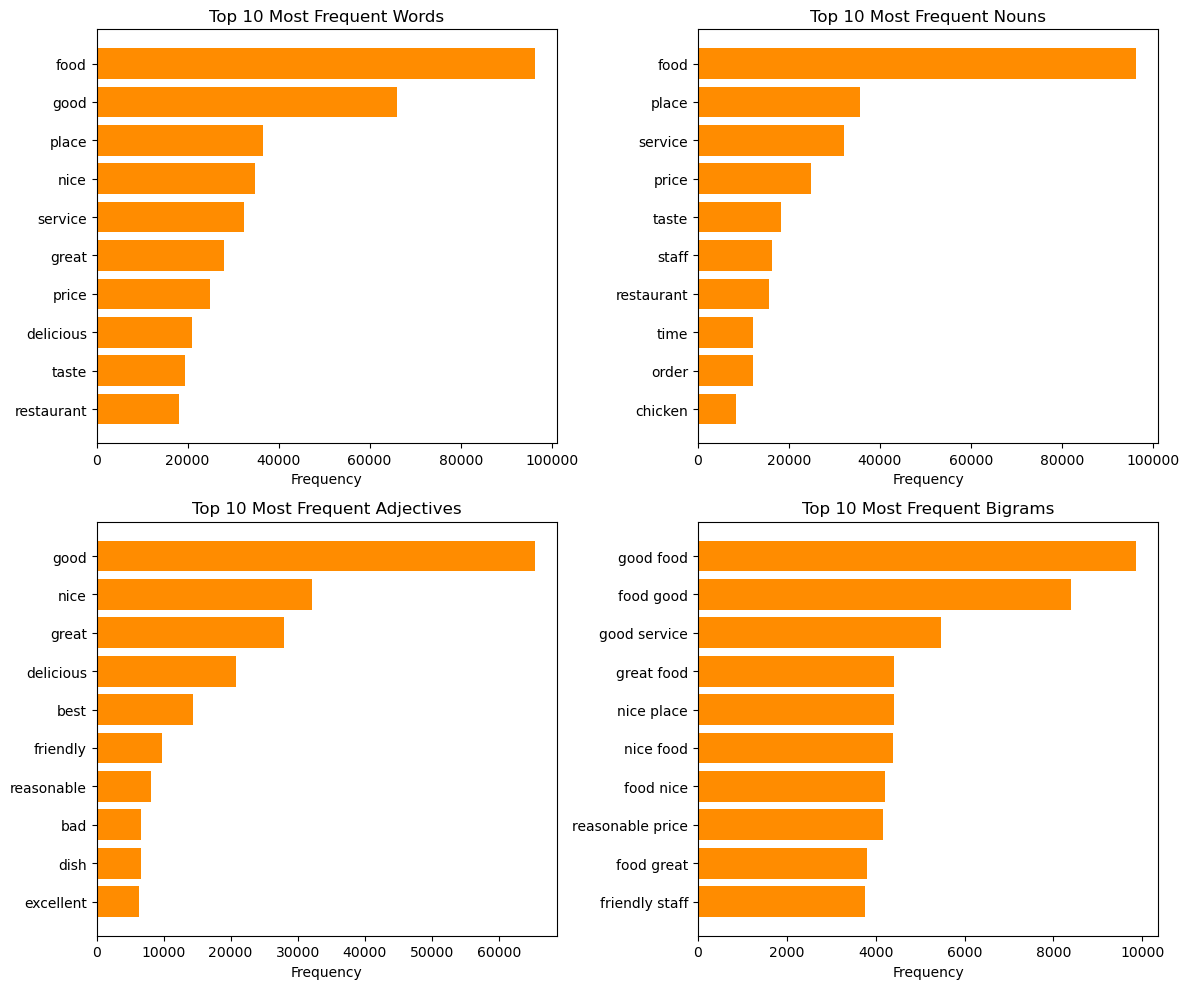

In [21]:
from nltk import FreqDist, pos_tag, ngrams
from collections import Counter
import matplotlib.pyplot as plt

all_tokens = [token for tokens_list in df['lemmatized'] for token in tokens_list]

# --- Q1: Top 10 most frequent words ---
fdist = FreqDist(all_tokens)
most_common = fdist.most_common(10)

# --- Q2: Top 10 Nouns ---
nouns = [w for (w, pos) in pos_tag(all_tokens) if pos.startswith('N')]
nou_freq = FreqDist(nouns).most_common(10)

# --- Q3: Top 10 adjectives ---
adjectives = [w for (w, pos) in pos_tag(all_tokens) if pos.startswith('J')]
adj_freq = FreqDist(adjectives).most_common(10)

# --- Q4: Top 10 bigrams ---
bigrams = [' '.join(bg) for bg in ngrams(all_tokens, 2)]
bigram_freq = Counter(bigrams).most_common(10)

# --- Plot setup ---
fig, axes = plt.subplots(2, 2, figsize=(12,10))
axes = axes.flatten()
datasets = [most_common, nou_freq, adj_freq, bigram_freq]
titles = [
    "Top 10 Most Frequent Words",
    "Top 10 Most Frequent Nouns",
    "Top 10 Most Frequent Adjectives",
    "Top 10 Most Frequent Bigrams"
]

for i, (data, title) in enumerate(zip(datasets, titles)):
    words, counts = zip(*data)
    axes[i].barh(words, counts, color="#FF8C00")
    axes[i].invert_yaxis()
    axes[i].set_title(title)
    axes[i].set_xlabel("Frequency")

plt.tight_layout()
plt.show()


## 5.2 Perform Analytics Tasks

### 5.2.1 Topic Modelling

#### Step 1. Finding the optimal number of topics

In [7]:
from gensim.corpora import Dictionary
import gensim

processed_docs = df['lemmatized'].tolist()
if isinstance(processed_docs[0], str):
    processed_docs = [doc.split() for doc in processed_docs]

review_dictionary = Dictionary(processed_docs)
review_dictionary.filter_extremes(no_below=10, no_above=0.5)
review_vecs = [review_dictionary.doc2bow(doc) for doc in processed_docs]

print("Dictionary size:", len(review_dictionary))
print(" Number of documents:", len(review_vecs))
print(processed_docs[0])

Dictionary size: 6713
 Number of documents: 198741
['come', 'high', 'tea', 'great', 'service', 'especially', 'jeet', 'friendly', 'accommodate', 'polite', 'thank', 'great', 'service']


In [ ]:
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import datetime

  
print(datetime.datetime.now())

x = range(2, 21, 2)  

coherence_values = []

for num_topics in x:
    print(f"[{datetime.datetime.now()}] k={num_topics}...")
    
    lda_model = gensim.models.LdaMulticore(
        corpus=review_vecs,          
        id2word=review_dictionary,   
        num_topics=num_topics,
        random_state=100,
        chunksize=1000,             
        passes=10,                  
        workers=4                   
    )

    coherence_model = CoherenceModel(
        model=lda_model,
        texts=processed_docs,      
        dictionary=review_dictionary, 
        coherence='c_v'
    )
    
    score = coherence_model.get_coherence()
    coherence_values.append(score)
    
    print(f"    k={num_topics}, Coherence Score = {score:.4f}")

print(datetime.datetime.now())


plt.figure(figsize=(12, 7))
plt.plot(x, coherence_values, marker='o')
plt.xlabel("Number of Topics, k)")
plt.ylabel("Coherence Score")
plt.title("Optimal number of topics", fontsize=16)
plt.xticks(x)
plt.grid(True)
plt.show()

if coherence_values:
    optimal_k_index = coherence_values.index(max(coherence_values))
    optimal_k = x[optimal_k_index]
    max_coherence_score = max(coherence_values)
    print(f"The highest scoring k is: {optimal_k} (Coherence Score: {max_coherence_score:.4f})")

Based on the highest coherence score, the intertopic distance map was generated for K = 12 to examine whether any topic overlapping issues were present.

In [ ]:
import gensim

OPTIMAL_K = 12
final_lda_model = gensim.models.LdaMulticore(
    corpus=review_vecs,               
     id2word=review_dictionary,    
    num_topics=OPTIMAL_K,
    random_state=100,
    chunksize=1000,
    passes=15,                  
    workers=4
)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(final_lda_model, review_vecs, review_dictionary)
vis 

In [ ]:
print(datetime.datetime.now())

x = range(6, 11, 1)  

coherence_values = []

for num_topics in x:
    print(f"[{datetime.datetime.now()}] k={num_topics}...")
    
    lda_model_1 = gensim.models.LdaMulticore(
        corpus=review_vecs,          
        id2word=review_dictionary,   
        num_topics=num_topics,
        random_state=100,
        chunksize=1000,             
        passes=10,                  
        workers=4                   
    )

    coherence_model_1 = CoherenceModel(
        model=lda_model_1,
        texts=processed_docs,      
        dictionary=review_dictionary, 
        coherence='c_v'
    )
    
    score = coherence_model_1.get_coherence()
    coherence_values.append(score)
    
    print(f"    k={num_topics}, Coherence Score = {score:.4f}")

print(datetime.datetime.now())

plt.figure(figsize=(12, 7))
plt.plot(x, coherence_values, marker='o')
plt.xlabel("Number of Topics, k)")
plt.ylabel("Coherence Score")
plt.title("Optimal number of topics", fontsize=16)
plt.xticks(x)
plt.grid(True)
plt.show()

if coherence_values:
    optimal_k_index = coherence_values.index(max(coherence_values))
    optimal_k = x[optimal_k_index]
    max_coherence_score = max(coherence_values)
    print(f"The highest scoring k is: {optimal_k} (Coherence Score: {max_coherence_score:.4f})")

In [ ]:
import gensim

OPTIMAL_K = 10
final_lda_model_1 = gensim.models.LdaMulticore(
    corpus=review_vecs,               
     id2word=review_dictionary,    
    num_topics=OPTIMAL_K,
    random_state=100,
    chunksize=1000,
    passes=15,                  
    workers=4
)
pyLDAvis.enable_notebook()
vis_10 = pyLDAvis.gensim_models.prepare(final_lda_model_1, review_vecs, review_dictionary)
vis_10

In [134]:
import gensim

OPTIMAL_K = 8
final_lda_model_2 = gensim.models.LdaMulticore(
    corpus=review_vecs,               
     id2word=review_dictionary,    
    num_topics=OPTIMAL_K,
    random_state=100,
    chunksize=1000,
    passes=15,                  
    workers=4
)
pyLDAvis.enable_notebook()
vis_8 = pyLDAvis.gensim_models.prepare(final_lda_model_2, review_vecs, review_dictionary)
vis_8

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.111492  0.147873       1        1  19.041972
4      0.042082 -0.215480       2        1  14.884777
6      0.150336 -0.021460       3        1  12.286947
3      0.116527  0.131960       4        1  12.116151
5     -0.261230 -0.012807       5        1  11.929005
7      0.170094 -0.242424       6        1  11.089286
0     -0.342690 -0.043465       7        1  10.462626
2      0.013388  0.255802       8        1   8.189235, topic_info=           Term          Freq         Total Category  logprob  loglift
28         food  92296.000000  92296.000000  Default  30.0000  30.0000
7       service  32544.000000  32544.000000  Default  29.0000  29.0000
144        best  17019.000000  17019.000000  Default  28.0000  28.0000
95        price  23943.000000  23943.000000  Default  27.0000  27.0000
74         nice  31510.000000  31510.000000  Default  26.0000  26.0000
..          ...           ...           ...      ...      ...      ...
33         love   1352.140715  11778.775164   Topic8  -4.8540   0.3377
75   restaurant   1417.585299  18160.187329   Topic8  -4.8067  -0.0479
229        meal   1133.130858   5240.453611   Topic8  -5.0307   0.9709
32         like   1078.747873  10977.357935   Topic8  -5.0799   0.1823
159       serve    999.681702  10626.609216   Topic8  -5.1560   0.1387

[490 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
830       3  0.999466        abit
439       1  0.305364  affordable
439       4  0.694429  affordable
563       2  0.998277         ago
1852      3  0.999232     alright
...     ...       ...         ...
2306      4  0.996892        xiao
1174      6  0.001944         yam
1174      7  0.997203         yam
568       2  0.999479        year
2125      6  0.998361         yum

[780 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 7, 4, 6, 8, 1, 3])

In [ ]:
import gensim

OPTIMAL_K = 6
final_lda_model_3 = gensim.models.LdaMulticore(
    corpus=review_vecs,               
     id2word=review_dictionary,    
    num_topics=OPTIMAL_K,
    random_state=100,
    chunksize=1000,
    passes=15,                  
    workers=4
)
pyLDAvis.enable_notebook()
vis_6 = pyLDAvis.gensim_models.prepare(final_lda_model_3, review_vecs, review_dictionary)
vis_6

,Word,Weight,Topic
0,best,0.059494,Topic 1
1,restaurant,0.042382,Topic 1
2,food,0.038499,Topic 1
3,one,0.029348,Topic 1
4,place,0.025067,Topic 1
5,authentic,0.018382,Topic 1
6,indian,0.017609,Topic 1
7,chinese,0.013787,Topic 1
8,kl,0.013638,Topic 1
9,cuisine,0.012985,Topic 1


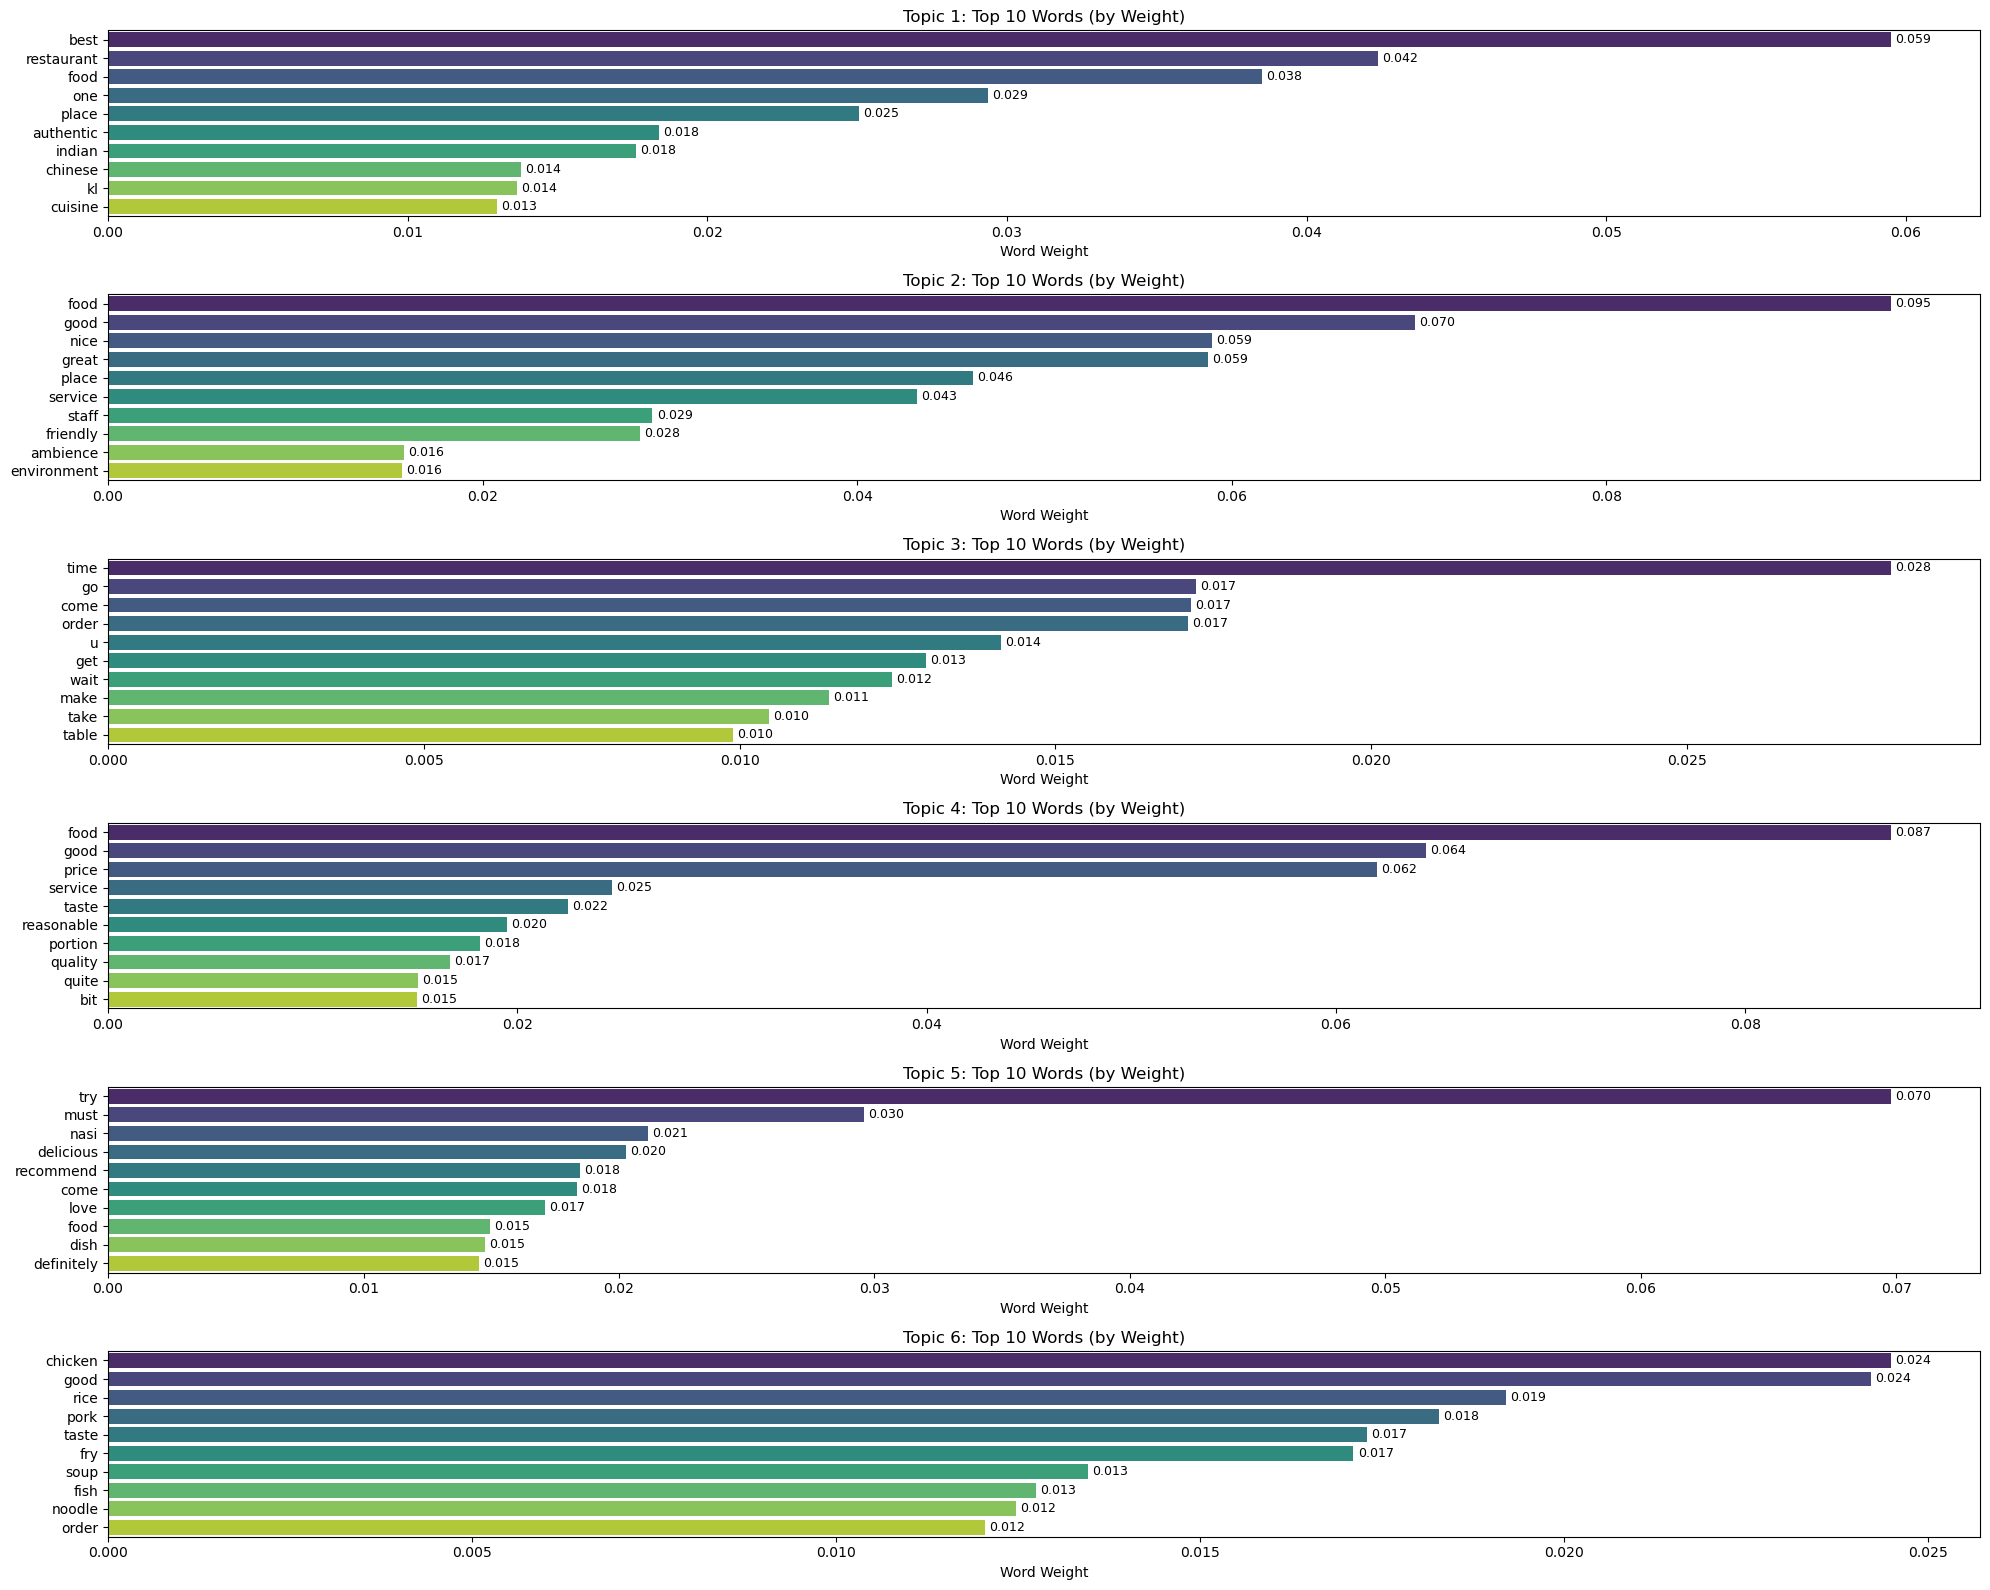

In [14]:
OPTIMAL_K = 6
num_words = 10
topics = final_lda_model_3.show_topics(num_topics=OPTIMAL_K, num_words=num_words, formatted=False)

topic_dfs = []

for topic_num, words in topics:
    df_topic = pd.DataFrame(words, columns=["Word", "Weight"])
    df_topic["Topic"] = f"Topic {topic_num + 1}"
    df_topic = df_topic.sort_values(by="Weight", ascending=False).reset_index(drop=True)
    topic_dfs.append(df_topic)

df_all_topics = pd.concat(topic_dfs, ignore_index=True)

pd.set_option('display.max_colwidth', None)
display(df_all_topics)


import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore", category=FutureWarning)

top_n = 10
plt.figure(figsize=(20, 16))

for i in range(1, OPTIMAL_K + 1):
    df_topic = df_all_topics[df_all_topics["Topic"] == f"Topic {i}"].head(top_n)
    
    plt.subplot(OPTIMAL_K, 1, i)
    ax = sns.barplot(
        x="Weight",
        y="Word",
        hue="Word",         
        dodge=False,
        data=df_topic,
        palette="viridis",
        legend=False
    )
    

    for container in ax.containers:
        ax.bar_label(container, fmt="%.3f", label_type="edge", fontsize=9, padding=3)
    
    plt.title(f"Topic {i}: Top {top_n} Words (by Weight)", fontsize=12)
    plt.xlabel("Word Weight", fontsize=10)
    plt.ylabel("")

plt.tight_layout()
plt.show()


#### Step 2:Create namelist for each topic and assign to each reviews

In [15]:
#creat topice name list
topic_names = {
    0: "Cuisine Variety",
    1: "Hospitality Experience ",
    2: "Wait Time",
    3: "Value for Money",
    4: "Customer Loyalty",
    5: "Food Taste",
}

import pandas as pd
def get_dominant_topic(doc_bow, final_lda_model_3):
    topic_distribution = final_lda_model_3[doc_bow]
    if isinstance(topic_distribution, tuple):
        topic_distribution = topic_distribution[0]
    if not topic_distribution:
        return -1  
    dominant_topic = sorted(topic_distribution, key=lambda x: x[1], reverse=True)[0][0]
    return dominant_topic
df['dominant_topic_id'] = [get_dominant_topic(doc_bow, final_lda_model_3) for doc_bow in review_vecs]

unassigned_reviews = df[df['dominant_topic_id'] == -1].shape[0]
if unassigned_reviews > 0:
    print(f"{unassigned_reviews} of reviews, didnt assigned topics")

df['dominant_topic_name'] = df['dominant_topic_id'].map(topic_names)
df['dominant_topic_name'] = df['dominant_topic_name'].fillna("Unassigned")
review_topic_table = df[['Review', 'dominant_topic_name']]
pd.set_option('display.max_colwidth', None)
display(review_topic_table.head(1))


,Review,dominant_topic_name
0,"Came here for the High Tea. Great service especially by Mr. Jeet. He's friendly, accommodating and polite. Thank you for your great service.",Hospitality Experience


Distribution of the number of reviews by theme:
dominant_topic_name
Hospitality Experience     57427
Value for Money            39317
Dish Selection             35372
Wait Time                  25698
Cuisine Variety            20999
Customer Loyalty           19928
Name: count, dtype: int64


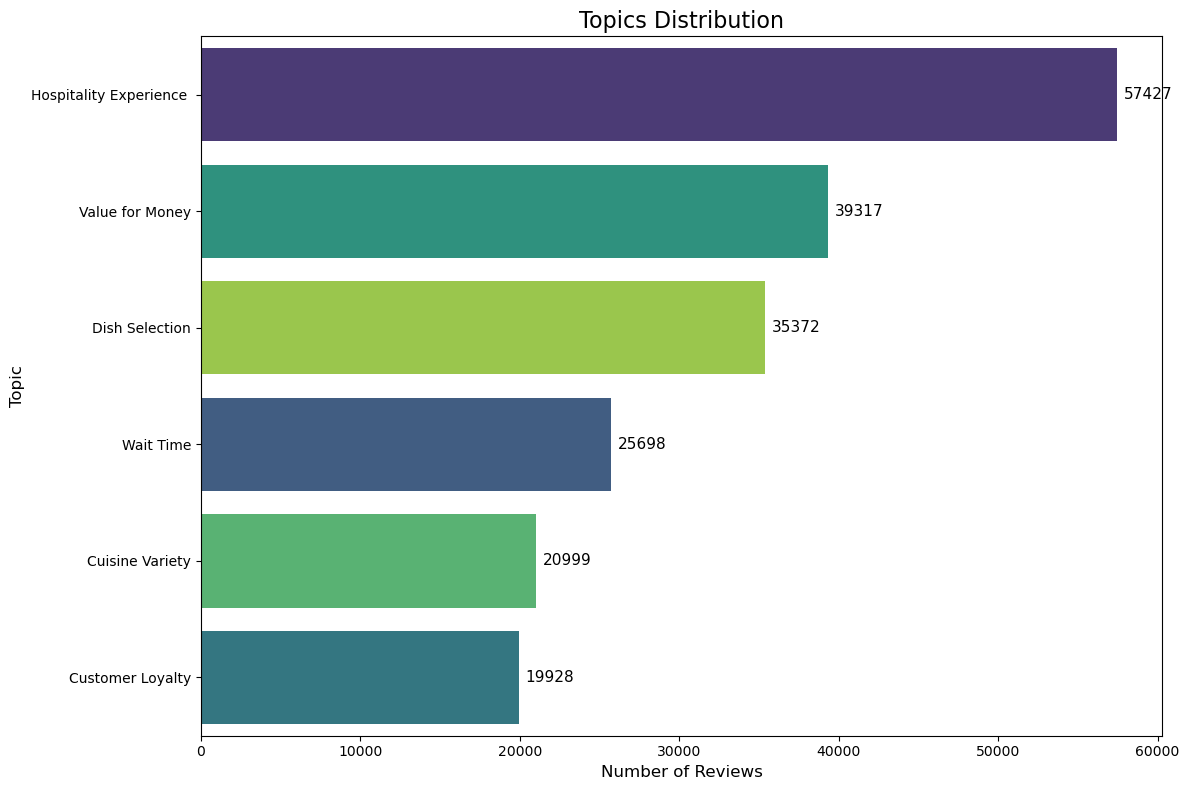

In [232]:
import seaborn as sns
import matplotlib.pyplot as plt

topic_distribution = df['dominant_topic_name'].value_counts()

print("Distribution of the number of reviews by theme:")
print(topic_distribution)


plt.figure(figsize=(12, 8))
ax = sns.countplot(
    y='dominant_topic_name', 
    data=df, 
    order=topic_distribution.index, 
    palette='viridis',
    hue='dominant_topic_name',
    legend=False
)


for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=11, padding=5)


plt.title('Topics Distribution', fontsize=16)
plt.xlabel('Number of Reviews', fontsize=12)
plt.ylabel('Topic', fontsize=12)

plt.tight_layout()
plt.show()


### 5.2.2 Sentiment Analysis

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/soumyadeepsarkar/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


=== VADER Evaluation (full dataset) ===
              precision    recall  f1-score   support

    negative       0.58      0.50      0.54     20362
     neutral       0.19      0.19      0.19     22323
    positive       0.87      0.88      0.87    156056

    accuracy                           0.76    198741
   macro avg       0.54      0.52      0.53    198741
weighted avg       0.76      0.76      0.76    198741



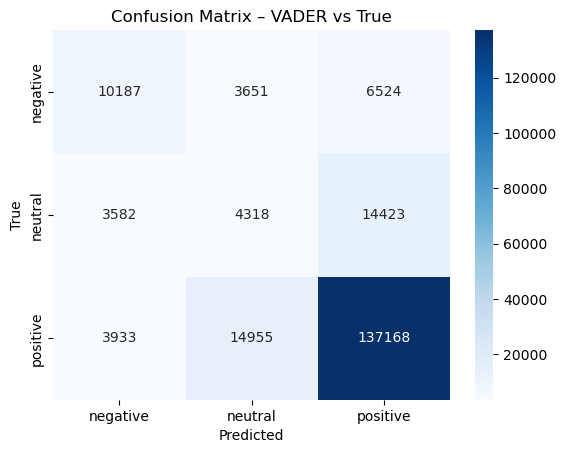


VADER breakdown (% per true label):
 vader_pred      negative  neutral  positive
true_sentiment                             
negative           50.03    17.93     32.04
neutral            16.05    19.34     64.61
positive            2.52     9.58     87.90

Class ratios (train/val/test):
Train:  {'positive': 78.52, 'neutral': 11.23, 'negative': 10.25}
Validation:  {'positive': 78.52, 'neutral': 11.23, 'negative': 10.25}
Test:  {'positive': 78.52, 'neutral': 11.23, 'negative': 10.24}

=== VADER on Test Only ===
Accuracy:  0.767
Macro-F1:  0.536

=== Validation (Naïve Bayes) ===
Accuracy:  0.804
Macro-F1:  0.403
              precision    recall  f1-score   support

    negative       0.93      0.18      0.31      3055
     neutral       0.58      0.01      0.01      3348
    positive       0.80      1.00      0.89     23408

    accuracy                           0.80     29811
   macro avg       0.77      0.40      0.40     29811
weighted avg       0.79      0.80      0.73     29811



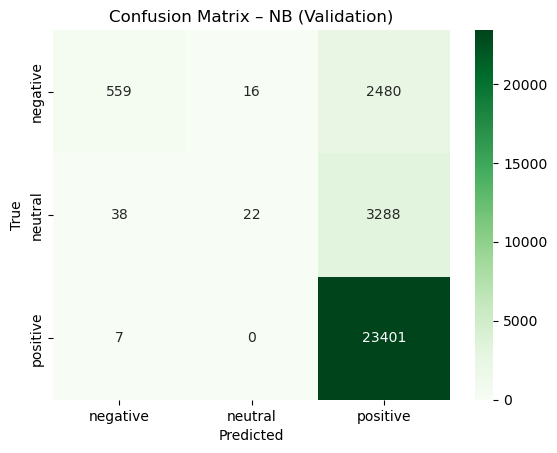


=== Test (Naïve Bayes – Final) ===
Accuracy:  0.804
Macro-F1:  0.399
              precision    recall  f1-score   support

    negative       0.91      0.17      0.29      3054
     neutral       0.75      0.01      0.02      3349
    positive       0.80      1.00      0.89     23409

    accuracy                           0.80     29812
   macro avg       0.82      0.39      0.40     29812
weighted avg       0.81      0.80      0.73     29812



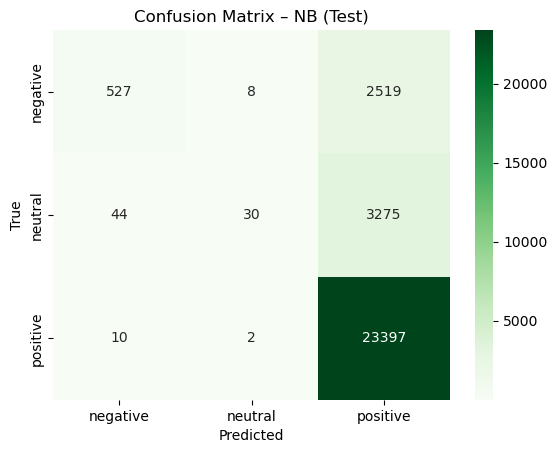


=== Validation (Logistic Regression / MaxEnt) ===
Accuracy:  0.810
Macro-F1:  0.667
              precision    recall  f1-score   support

    negative       0.62      0.78      0.69      3055
     neutral       0.35      0.49      0.41      3348
    positive       0.95      0.86      0.90     23408

    accuracy                           0.81     29811
   macro avg       0.64      0.71      0.67     29811
weighted avg       0.85      0.81      0.82     29811



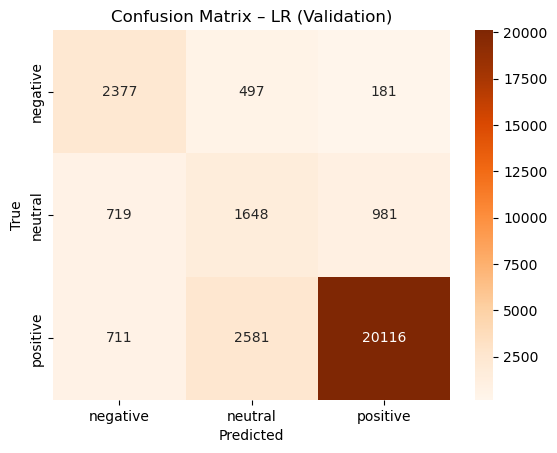


=== Test (Logistic Regression / MaxEnt – Final) ===
Accuracy:  0.806
Macro-F1:  0.665
              precision    recall  f1-score   support

    negative       0.62      0.76      0.68      3054
     neutral       0.35      0.51      0.41      3349
    positive       0.95      0.85      0.90     23409

    accuracy                           0.81     29812
   macro avg       0.64      0.71      0.67     29812
weighted avg       0.85      0.81      0.82     29812



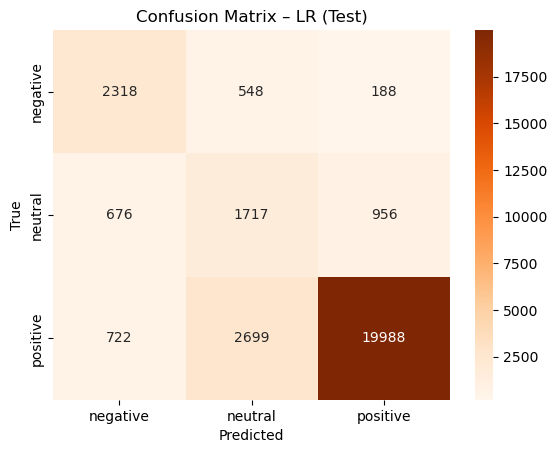

In [16]:
import pandas as pd, numpy as np
import seaborn as sns, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression            
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

def map_rating_to_sentiment(r):       
    if r >= 4: return 'positive'
    elif r == 3: return 'neutral'
    else: return 'negative'

df['Review'] = df['Review'].fillna('').astype(str)            
df['true_sentiment'] = df['Rating'].apply(map_rating_to_sentiment)

import nltk
try:
    nltk.data.find('sentiment/vader_lexicon')                  
except LookupError:
    nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

def score_to_label(v):                                   
    if v >= 0.05:  return 'positive'
    elif v <= -0.05:return 'negative'
    else:             return 'neutral'

df['vader_score'] = df['Review'].apply(lambda x: sia.polarity_scores(x)['compound'])
df['vader_pred']  = df['vader_score'].apply(score_to_label)

LABELS = ['negative','neutral','positive']                    
print("=== VADER Evaluation (full dataset) ===")
print(classification_report(df['true_sentiment'], df['vader_pred'], labels=LABELS, zero_division=0))

cm_vader = confusion_matrix(df['true_sentiment'], df['vader_pred'], labels=LABELS)
sns.heatmap(cm_vader, annot=True, fmt='d', cmap='Blues',
            xticklabels=LABELS, yticklabels=LABELS)
plt.title("Confusion Matrix – VADER vs True"); plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

vader_pct = (pd.crosstab(df['true_sentiment'], df['vader_pred'], normalize='index')
             .reindex(index=LABELS, columns=LABELS, fill_value=0.0)*100).round(2)
print("\nVADER breakdown (% per true label):\n", vader_pct)

X, y = df['Review'], df['true_sentiment']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)
X_val,   X_test, y_val,   y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

print("\nClass ratios (train/val/test):")
for name, yy in [("Train", y_train), ("Validation", y_val), ("Test", y_test)]:
    print(f"{name}: ", (yy.value_counts(normalize=True)*100).round(2).to_dict())

vader_test_pred = pd.Series(X_test).apply(lambda t: score_to_label(sia.polarity_scores(t)['compound']))
print("\n=== VADER on Test Only ===")
print(f"Accuracy:  {accuracy_score(y_test, vader_test_pred):.3f}")
print(f"Macro-F1:  {f1_score(y_test, vader_test_pred, average='macro'):.3f}")


nb_clf = Pipeline([
    ('tfidf', TfidfVectorizer(
        ngram_range=(1,2),          
        min_df=2,                 
        strip_accents='unicode',  
        sublinear_tf=True,         
        token_pattern=r'(?u)\b\w+\b'
    )),
    ('nb', MultinomialNB(alpha=1.0))
])


nb_clf.fit(X_train, y_train)

y_val_pred = nb_clf.predict(X_val)
print("\n=== Validation (Naïve Bayes) ===")
print(f"Accuracy:  {accuracy_score(y_val, y_val_pred):.3f}")
print(f"Macro-F1:  {f1_score(y_val, y_val_pred, average='macro'):.3f}")
print(classification_report(y_val, y_val_pred, labels=LABELS, zero_division=0))

cm_val = confusion_matrix(y_val, y_val_pred, labels=LABELS)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens',
            xticklabels=LABELS, yticklabels=LABELS)
plt.title("Confusion Matrix – NB (Validation)"); plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

y_test_pred = nb_clf.predict(X_test)
print("\n=== Test (Naïve Bayes – Final) ===")
print(f"Accuracy:  {accuracy_score(y_test, y_test_pred):.3f}")
print(f"Macro-F1:  {f1_score(y_test, y_test_pred, average='macro'):.3f}")
print(classification_report(y_test, y_test_pred, labels=LABELS, zero_division=0))

cm_test = confusion_matrix(y_test, y_test_pred, labels=LABELS)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens',
            xticklabels=LABELS, yticklabels=LABELS)
plt.title("Confusion Matrix – NB (Test)"); plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

logit_clf = Pipeline([
    ('tfidf', TfidfVectorizer(
        ngram_range=(1,2),
        min_df=1,                  
        max_df=0.9,                 
        strip_accents='unicode',
        sublinear_tf=True,
        token_pattern=r'(?u)\b\w+\b'
    )),
    ('lr', LogisticRegression(max_iter=2000, class_weight='balanced'))  # handle imbalance
])

logit_clf.fit(X_train, y_train)

y_val_logit = logit_clf.predict(X_val)
print("\n=== Validation (Logistic Regression / MaxEnt) ===")
print(f"Accuracy:  {accuracy_score(y_val, y_val_logit):.3f}")
print(f"Macro-F1:  {f1_score(y_val, y_val_logit, average='macro'):.3f}")
print(classification_report(y_val, y_val_logit, labels=LABELS, zero_division=0))

cm_val_logit = confusion_matrix(y_val, y_val_logit, labels=LABELS)
sns.heatmap(cm_val_logit, annot=True, fmt='d', cmap='Oranges',
            xticklabels=LABELS, yticklabels=LABELS)
plt.title("Confusion Matrix – LR (Validation)"); plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

y_test_logit = logit_clf.predict(X_test)
print("\n=== Test (Logistic Regression / MaxEnt – Final) ===")
print(f"Accuracy:  {accuracy_score(y_test, y_test_logit):.3f}")
print(f"Macro-F1:  {f1_score(y_test, y_test_logit, average='macro'):.3f}")
print(classification_report(y_test, y_test_logit, labels=LABELS, zero_division=0))

cm_test_logit = confusion_matrix(y_test, y_test_logit, labels=LABELS)
sns.heatmap(cm_test_logit, annot=True, fmt='d', cmap='Oranges',
            xticklabels=LABELS, yticklabels=LABELS)
plt.title("Confusion Matrix – LR (Test)"); plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

## 5.3 Aggregate Insight and Provide Recommendation

In [30]:
df['split'] = 'full'
df.loc[X_train.index, 'split'] = 'train'
df.loc[X_val.index,   'split'] = 'val'
df.loc[X_test.index,  'split'] = 'test'

logit_proba = logit_clf.predict_proba(df['Review'])
proba_cols = [f'logit_p_{c}' for c in logit_clf.classes_] 
proba_df = pd.DataFrame(logit_proba, columns=proba_cols, index=df.index)

df = pd.concat([df, proba_df], axis=1)

df['logit_pred'] = logit_clf.predict(df['Review'])
df['logit_conf'] = df[proba_cols].max(axis=1)

df['final_model'] = 'logistic_regression'
df['final_pred']  = df['logit_pred']
df['final_conf']  = df['logit_conf']

df.head()

,Author,Rating,Review,Restaurant,Location,tokens,clean_tokens,no_stopwords,lemmatized,sentiment,...,vader_pred,split,logit_p_negative,logit_p_neutral,logit_p_positive,logit_pred,logit_conf,final_model,final_pred,final_conf
0,Jia Pin Lee,4.0,Came here for the High Tea. Great service espe...,Cuisines Restaurant,Ipoh,"[came, here, for, the, high, tea, ., great, se...","[came, here, for, the, high, tea, great, servi...","[came, high, tea, great, service, especially, ...","[come, high, tea, great, service, especially, ...",positive,...,positive,train,0.009415,0.039158,0.951427,positive,0.951427,logistic_regression,positive,0.951427
1,Chui Yi Lum,2.0,"5 stars for the service, even though some of t...",Cuisines Restaurant,Ipoh,"[5, stars, for, the, service, ,, even, though,...","[stars, for, the, service, even, though, some,...","[stars, service, even, though, staffs, need, t...","[star, service, even, though, staff, need, tra...",negative,...,positive,train,0.687801,0.243235,0.068963,negative,0.687801,logistic_regression,negative,0.687801
2,liezel wong,1.0,"Hi, thank you for your service. But! i feel so...",Cuisines Restaurant,Ipoh,"[hi, ,, thank, you, for, your, service, ., but...","[hi, thank, you, for, your, service, but, i, f...","[hi, thank, service, feel, sorry, food, deserv...","[hi, thank, service, feel, sorry, food, deserv...",negative,...,positive,train,0.733182,0.133379,0.133439,negative,0.733182,logistic_regression,negative,0.733182
3,Nazri Nor,1.0,I have the worse buffer dinner ever so far. Th...,Cuisines Restaurant,Ipoh,"[i, have, the, worse, buffer, dinner, ever, so...","[i, have, the, worse, buffer, dinner, ever, so...","[worse, buffer, dinner, ever, far, spread, sma...","[bad, buffer, dinner, ever, far, spread, small...",negative,...,negative,train,0.923334,0.057658,0.019009,negative,0.923334,logistic_regression,negative,0.923334
4,Fakru Imran's Channel,5.0,"That's are Known 5 Elmark "" 9H72 "" & KDK "" 3 K...",Cuisines Restaurant,Ipoh,"[that, 's, are, known, 5, elmark, ``, 9h72, ``...","[that, are, known, elmark, kdk, ceiling, fan, ...","[known, elmark, kdk, ceiling, fan, ca, believe...","[know, elmark, kdk, ceiling, fan, ca, believe,...",positive,...,positive,train,0.398257,0.395129,0.206614,negative,0.398257,logistic_regression,negative,0.398257


## Comparing across the different cities

In [ ]:
#text classification summary

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


cities = df['Location'].dropna().unique()


for city in cities:
    city_df = df[df['Location'] == city]


    topic_sent_counts = (
        city_df.groupby(['dominant_topic_name', 'final_pred'])
               .size()
               .reset_index(name='count')
    )


    topic_sent_counts['pct'] = (
        topic_sent_counts.groupby('dominant_topic_name')['count']
                         .apply(lambda x: 100 * x / x.sum())
                         .values
    )

 
    plt.figure(figsize=(10,6))
    sns.barplot(
        data=topic_sent_counts,
        x='dominant_topic_name', y='pct', hue='final_pred',
        palette={'positive':'green', 'neutral':'gray', 'negative':'red'}
    )
    plt.title(f"Sentiment Distribution by Topic – {city}")
    plt.ylabel("Percentage (%)")
    plt.xlabel("Topic")
    plt.xticks(rotation=45, ha='right')
    plt.legend(title="Predicted Sentiment")
    plt.tight_layout()
    plt.show()


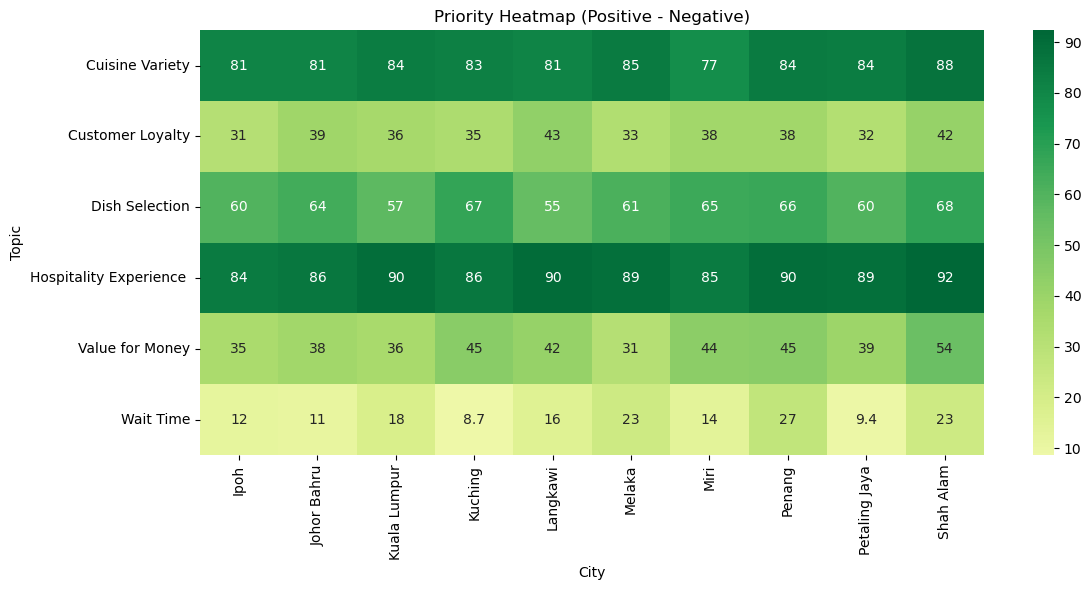


--- Ranked Topics by City (Lowest scores = highest priority to fix) ---
final_pred           City      dominant_topic_name  PriorityScore
5                    Ipoh                Wait Time      11.833910
1                    Ipoh         Customer Loyalty      31.263383
4                    Ipoh          Value for Money      35.135135
2                    Ipoh           Dish Selection      60.005273
0                    Ipoh          Cuisine Variety      81.496711
3                    Ipoh  Hospitality Experience       84.207992
5             Johor Bahru                Wait Time      11.370882
4             Johor Bahru          Value for Money      37.619048
1             Johor Bahru         Customer Loyalty      38.846309
2             Johor Bahru           Dish Selection      63.595068
0             Johor Bahru          Cuisine Variety      81.200289
3             Johor Bahru  Hospitality Experience       85.868902
5            Kuala Lumpur                Wait Time      18.276160
4  

In [240]:
cities = df['Location'].dropna().unique()
priority_list = []

for city in cities:
    city_df = df[df['Location'] == city]
    
    # Count sentiment per topic
    topic_sent_counts = city_df.groupby(['dominant_topic_name','final_pred']).size().unstack(fill_value=0)
    
    # Convert to percentages
    topic_sent_pct = topic_sent_counts.div(topic_sent_counts.sum(axis=1), axis=0) * 100
    
    # Compute flipped priority score: positive - negative
    topic_sent_pct['PriorityScore'] = topic_sent_pct.get('positive',0) - topic_sent_pct.get('negative',0)
    topic_sent_pct['City'] = city
    topic_sent_pct['dominant_topic_name'] = topic_sent_pct.index
    priority_list.append(topic_sent_pct.reset_index(drop=True))

priority_df = pd.concat(priority_list)

# Heatmap of priority scores
pivot_df = priority_df.pivot(index='dominant_topic_name', columns='City', values='PriorityScore')

plt.figure(figsize=(12,6))
sns.heatmap(pivot_df, annot=True, cmap="RdYlGn", center=0)
plt.title("Priority Heatmap (Positive - Negative)")
plt.ylabel('Topic')
plt.xlabel("City")
plt.tight_layout()
plt.show()


#  Ranked table for action
priority_df_sorted = priority_df.sort_values(['City','PriorityScore'], ascending=[True, True])
print("\n--- Ranked Topics by City (Lowest scores = highest priority to fix) ---")
print(priority_df_sorted[['City','dominant_topic_name','PriorityScore']])

In [ ]:
import pickle

# Exporting our models
with open("sentiment_model.pkl", "wb") as f:
    pickle.dump(logit_clf, f) 

print("Model saved successfully!")

with open("lda_model.pkl", "wb") as f:
    pickle.dump(final_lda_model_3, f)

with open("dictionary.pkl", "wb") as f:
    pickle.dump(review_dictionary, f)

print("Model saved successfully!")

# Positive: I love the Nasi Lemak in this restaurant !! 
# Negative: I hate the Nasi Lemak in this restaurant !! JB confirm got better options
# Neutral: The seating time in the restaurant was not bad, though a bit cramped during peak hours. Overall, it was an average dining experience.


Model saved successfully!
Model saved successfully!


In [22]:
import pickle

# Check model
with open("sentiment_model.pkl", "rb") as f:
    model = pickle.load(f)
print("Model type:", type(model))

Model type: <class 'sklearn.pipeline.Pipeline'>
